# Classification of Human Emotion through Speech

## Data Set Citation: https://zenodo.org/record/1188976

### The objective of this project is to be able to classify human emotions from speech. This is something that can be useful in cusomer service, sales, fraud detection etc. I will be making use of the Librosa library for sound analysis.

In [74]:
import librosa, librosa.display
import soundfile
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Exploration

### In this project we will be exploring the emotions; 'calm', 'happy', 'fearful', 'disgust'.
### Let's start by taking a look at a sample time domain waveform for each emotion.

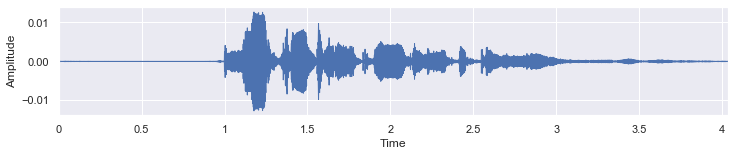

The above wave is for a sample 'calm' audio file.



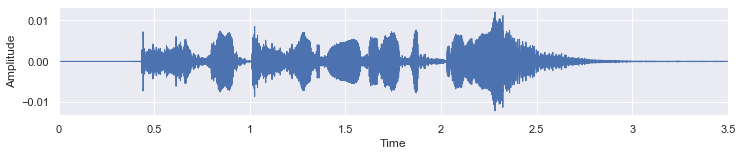

The above wave is for a sample 'disgust' audio file.



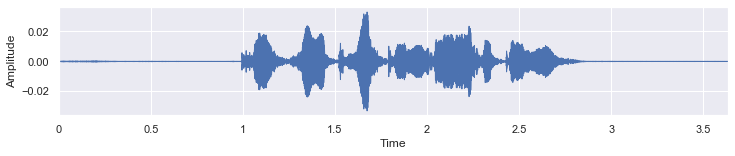

The above wave is for a sample 'fearful' audio file.



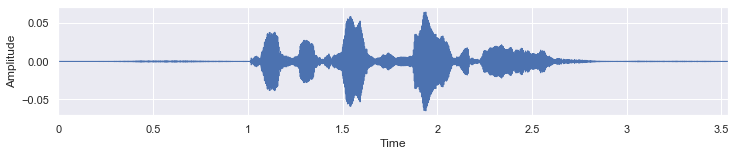

The above wave is for a sample 'happy' audio file.



In [75]:
for sample in os.listdir(".\sampleaudio"):
    plt.figure(figsize=(12,2))
    route = ".\sampleaudio" + '\\' + sample
    signal, sr = librosa.load(route, sr=22050)
    librosa.display.waveplot(signal, sr=sr)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()
    print(f"The above wave is for a sample '{sample[0:-4]}' audio file.\n")

### As we can see, we can't really make out much from the above visualizations. It would be difficult to manually classify speech from the above examples.

## How can we extract data from an audio file?

### Sound waves are digitised by sampling them at discrete intervals. The rate at which waves are sampled is called the 'sample rate'. Sampling a wave would give us an array of the amplitude values at various points on the wave as per the sampling rate.
### Before we do this, let's look at some features of sound.

## -  Below is the power spectrum of a sample sound wave.
### It displays the different frequencies present in a sound in terms of the amount of vibration at each individual frequency.

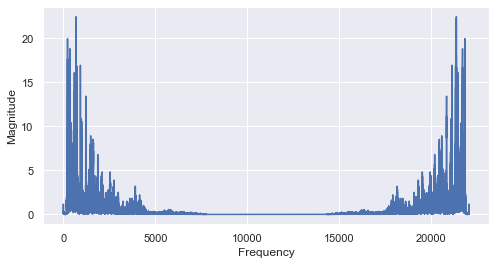

In [76]:
sns.set(rc={'figure.figsize':(8,4)})
# fast fourier transform
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

## - Below is the spectrogram of a sample sound wave.
### A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time.

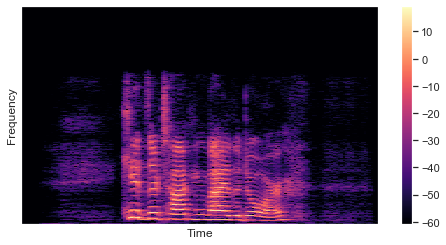

In [77]:
# stft
n_fft = 2048
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()
# spectrum

## - Below is the MFCC spectrogram of a sample sound wave.
### An MFCC spectrogram is very similar to a spectrogram but with more distinguishable detail. MFCC is a much more compressible representation.

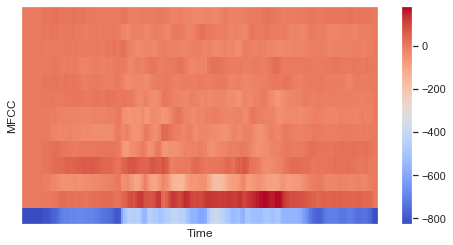

In [78]:
# MFCC
MFCCs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

# Data Extraction and Modelling

### I will only be exploring the 'calm', 'happy', 'fearful', and 'disgust' emotions as they are more distinct to each other compared to the other emotions.

In [117]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [80]:
# FUNCTION DEFINITION
# extract extracts mfcc, chroma and mel data from a sound
# file_name and the rest all true to extract all the required data
def extract(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        # digitising audio
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            # Short-time Fourier transform
            stft=np.abs(librosa.stft(X))
            # empty array
            result=np.array([])
        if mfcc:
            # MFCC = Mel Frequency Cepstral Coefficient
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            # modify array
            result=np.hstack((result, mfccs))
        if chroma:
            # chroma relates to the 12 different pitch classes
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            # modify array
            result=np.hstack((result, chroma))
        if mel:
            # mel
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            # modify array
            result=np.hstack((result, mel))
        return result
        # all sound data extracted

In [81]:
# FUNCTION DEFINITION
# calls extract and extracts data of all sound files that are 'calm', 'happy', 'fearful', or 'disgust'
def load_data():
    x,y=[],[]
    for file in glob.glob(".\speech-emotion-recognition-ravdess-data\\Actor_*\\*.wav"): # directory containing sound data
        file_name=os.path.basename(file)
        # emotion is in the third number in file name
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue # if not 'calm', 'happy', 'fearful', or 'disgust'
        feature=extract(file, mfcc=True, chroma=True, mel=True) # calls extract function
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, random_state=9)

In [82]:
x_train,x_test,y_train,y_test=load_data() # loading all data before modelling

In [83]:
print("Shapes:\nx_train: ", x_train.shape, "\nx_test: ", x_test.shape)
## checking whether we have the correct sizes

Shapes:
x_train:  (576, 180) 
x_test:  (192, 180)


In [84]:
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [85]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [113]:
model.fit(x_train,y_train) # fitting the model

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [114]:
y_pred=model.predict(x_test) # predicted emotions

In [115]:
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.3f}%".format(accuracy*100))

Accuracy: 79.688%


# ~ ~ ~ ~ ~ Accuracy achieved: 79.69% ~ ~ ~ ~ ~

# Confusion Matrix

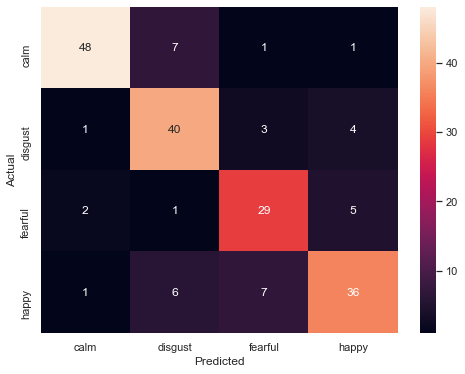

In [116]:
sns.set(rc={'figure.figsize':(8,6)})
data = {'y_Actual':    y_test,
        'y_Predicted': y_pred
       }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

## We can see that the model struggles with the following:
### - Confuses 'calm' for 'disgust'
### - Confuses 'happy' for 'disgust' and 'fearful'
### - Confuses 'fearful' for 'happy'

### Overall there are mistakes being made for all emotions. However, the general accuracy is decent considering how difficult it is to classify emotions. It is possible to express (in speech) multiple emotions at one time.

# - - - - - - - - - - - - - - - - Accuracy achieved: 79.69% - - - - - - - - - - - - - - - - 